<h1><center>Multiclass classification model using a custom convolutional neural network in TensorFlow. </center></h1>

#### Problem statement:
 To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


#### Steps Involved:

1) Data Reading/Data Understanding
2) Dataset Creation
3) Dataset visualisation
4) Model Building & training
5) Chose an appropriate data augmentation strategy to resolve underfitting/overfitting 
6) Model Building & training on the augmented data
7) Class distribution 
8) Handling class imbalances
9) Model Building & training on the rectified class imbalance data

In [1]:
import pathlib
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix
import itertools
import os
import PIL
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls "/content/gdrive/My Drive/Colab Notebooks/CNN_ASSIGNMENT/"

CNN_assignment.zip


In [4]:
!unzip '/content/gdrive/My Drive/Colab Notebooks/CNN_ASSIGNMENT/CNN_assignment.zip' -d '/content/gdrive/My Drive/Colab Notebooks/CNN_ASSIGNMENT/'

Archive:  /content/gdrive/My Drive/Colab Notebooks/CNN_ASSIGNMENT/CNN_assignment.zip
  inflating: /content/gdrive/My Drive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/My Drive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/My Drive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/My Drive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/My Drive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/My Drive/Colab Notebo

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load off these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Let's define some parameters for the loader.

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Let's split train data as 80% for training and 20% for validation

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Data Visualization

#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [11]:
class_to_img = {}
search_class = 0
for element in train_ds:
  for count,class_value in enumerate(element[1].numpy()):
      if class_value == search_class:
            class_to_img[search_class] = element[0][count]
            search_class += 1
            if search_class == 9:
                          break
  if search_class == 9:
   break
### your code goes here, you can use training or validation data to visualize
print(class_to_img.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])


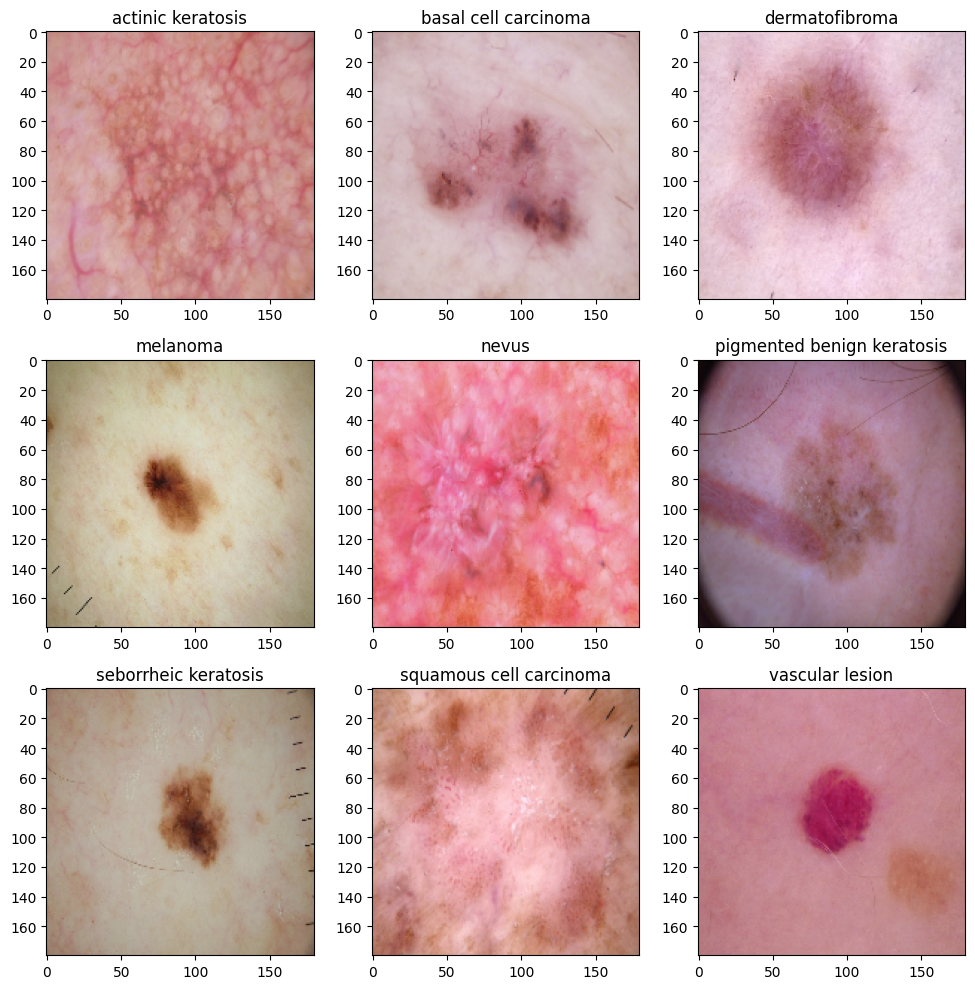

In [12]:
plt.figure(figsize=(10,10))
for i in range(9):
  img_data = class_to_img[i]
  plt.subplot(3,3, i+1)
  plt.imshow(np.float32(img_data/255))
  plt.title(class_names[i])
  plt.tight_layout()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model
Choosing an appropirate optimiser and also the loss function for model training

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Model Training

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 84s 1s/step - loss: 2.0355 - accuracy: 0.2734 - val_loss: 1.8469 - val_accuracy: 0.3624
Epoch 2/20
56/56 [==============================] - 61s 1s/step - loss: 1.7456 - accuracy: 0.3750 - val_loss: 1.6110 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 65s 1s/step - loss: 1.4949 - accuracy: 0.4810 - val_loss: 1.4712 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 61s 1s/step - loss: 1.3617 - accuracy: 0.5234 - val_loss: 1.4529 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 61s 1s/step - loss: 1.2540 - accuracy: 0.5631 - val_loss: 1.3843 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 59s 1s/step - loss: 1.1722 - accuracy: 0.5893 - val_loss: 1.4641 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 60s 1s/step - loss: 1.0749 - accuracy: 0.6250 - val_loss: 1.3983 - val_accuracy: 0.5145
Epoch 8/20
56/56 [==

#### Analysis training results

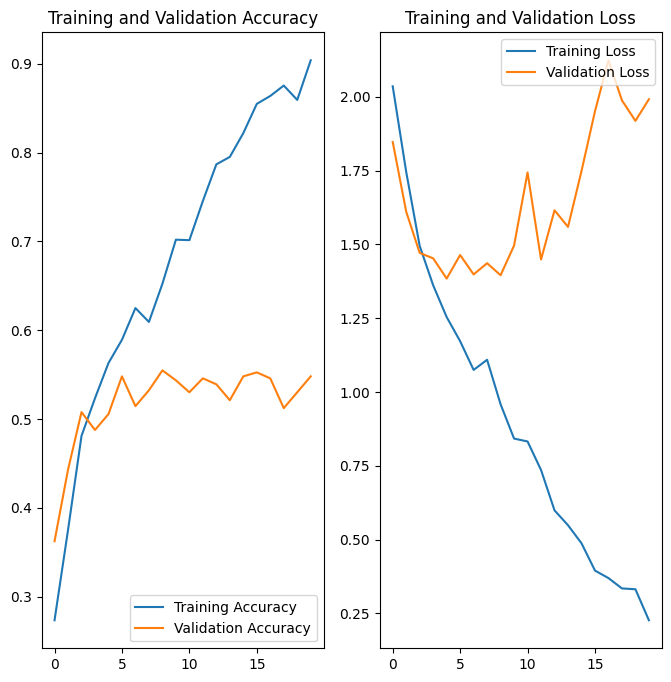

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### From the above results and graph we have Overfitting scenario where the model performed well on ```training data but performed poorly on data not seen during training and the Accuracy measured against the training set is very good but Validation Accuracy is not so good```


In [19]:
data_augmentation = tf.keras.Sequential([
layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
input_shape=(img_height,
img_width,
3), seed=123),
layers.experimental.preprocessing.RandomRotation(0.1, seed=123),
layers.experimental.preprocessing.RandomZoom(0.1,0.1, seed=123),
])

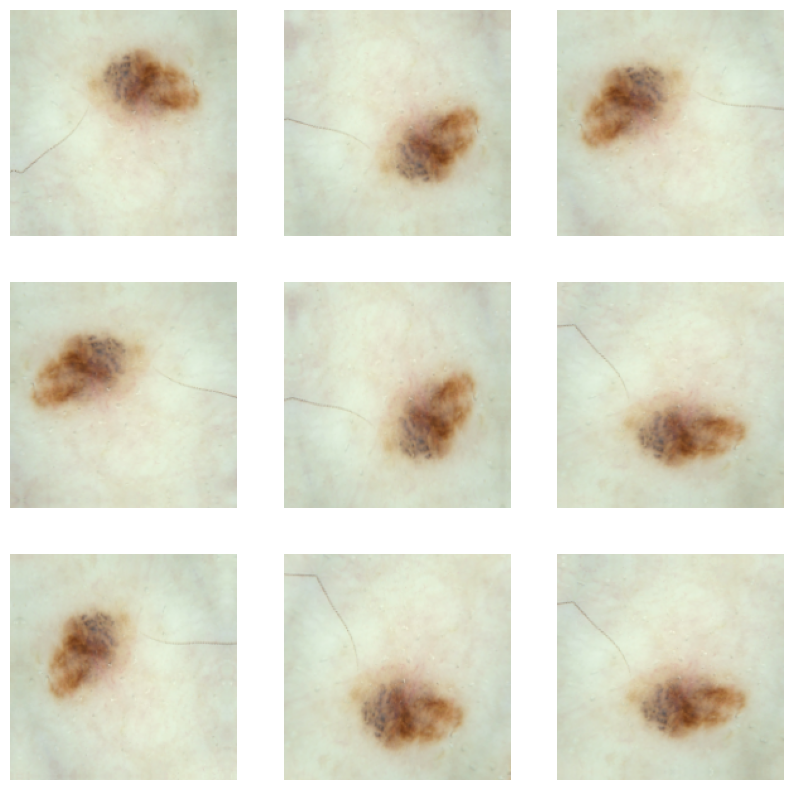

In [20]:
#visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

As there is overfitting we can create a dropout layer

In [21]:
model=Sequential([
    data_augmentation,
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

#### Compiling the model

In [22]:
model.compile(optimizer='adam',
              loss= tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### Model training for 20 epochs

In [23]:
epochs = 20
history = model.fit(x=train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=val_ds,
    validation_steps=len(val_ds),
    epochs=epochs,
    verbose=2
)

Epoch 1/20
56/56 - 146s - loss: 23.4010 - accuracy: 0.1568 - val_loss: 2.0541 - val_accuracy: 0.1924 - 146s/epoch - 3s/step
Epoch 2/20
56/56 - 144s - loss: 2.0921 - accuracy: 0.2221 - val_loss: 2.0385 - val_accuracy: 0.2550 - 144s/epoch - 3s/step
Epoch 3/20
56/56 - 140s - loss: 2.0440 - accuracy: 0.2344 - val_loss: 1.9680 - val_accuracy: 0.2371 - 140s/epoch - 2s/step
Epoch 4/20
56/56 - 143s - loss: 1.9892 - accuracy: 0.2522 - val_loss: 2.0255 - val_accuracy: 0.1902 - 143s/epoch - 3s/step
Epoch 5/20
56/56 - 140s - loss: 2.2167 - accuracy: 0.1925 - val_loss: 2.0401 - val_accuracy: 0.1812 - 140s/epoch - 2s/step
Epoch 6/20
56/56 - 143s - loss: 2.0749 - accuracy: 0.1735 - val_loss: 2.0295 - val_accuracy: 0.1812 - 143s/epoch - 3s/step
Epoch 7/20
56/56 - 138s - loss: 2.4993 - accuracy: 0.2076 - val_loss: 2.0413 - val_accuracy: 0.2125 - 138s/epoch - 2s/step
Epoch 8/20
56/56 - 144s - loss: 2.0762 - accuracy: 0.1936 - val_loss: 2.0487 - val_accuracy: 0.2036 - 144s/epoch - 3s/step
Epoch 9/20
56/5

#### Visualizing Test results

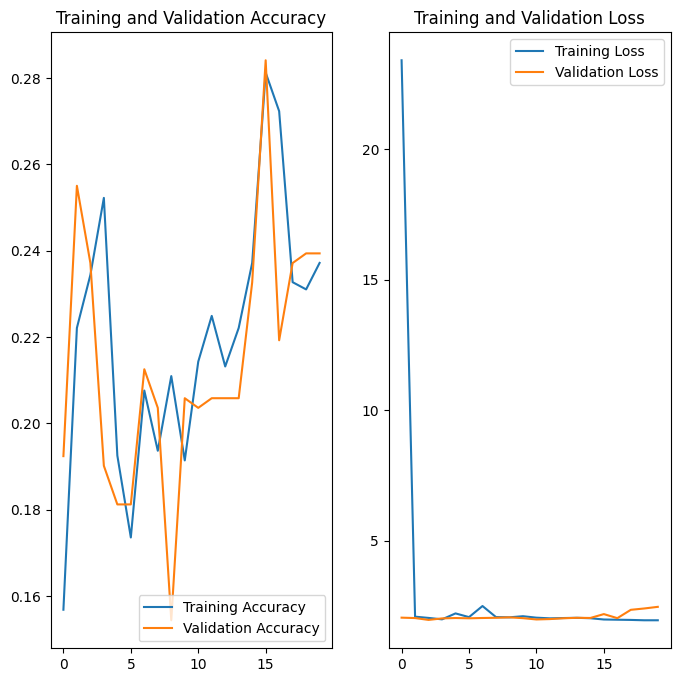

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### ````We can observe that after the Augmentation is done there's neither Overfitting nor Underfitting in the Model.````

Let's check for distribution of classes in the data

In [32]:
import glob
for i in class_names:
  directory =pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'+i+'/')
  length=len(list(directory.glob('*')))
  print(f'{i} contains {length}')

actinic keratosis contains 114
basal cell carcinoma contains 376
dermatofibroma contains 95
melanoma contains 438
nevus contains 357
pigmented benign keratosis contains 462
seborrheic keratosis contains 77
squamous cell carcinoma contains 181
vascular lesion contains 139


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
####  **Answer  :**

1.   seborrheic keratosis contains least (77) number of samples.
2.   Next Least is dermatofibroma which contains (95) number of samples.


#### - Which classes dominate the data in terms proportionate number of samples?
 ####  **Answer  :**

Below are order by count in decending order:

1.   pigmented benign keratosis
2.   melanoma
3.   basal cell carcinoma
4.   nevus

These Contains Proportionate number of Samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

### Data Augmentation

In [26]:
!pip install Augmentor

In [33]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A32292F0040>: 100%|██████████| 500/500 [00:26<00:00, 18.56 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A319216E590>: 100%|██████████| 500/500 [00:23<00:00, 21.46 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A317E0EB460>: 100%|██████████| 500/500 [00:22<00:00, 22.13 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A3192026DA0>: 100%|██████████| 500/500 [01:49<00:00,  4.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A3192180370>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A319216C760>: 100%|██████████| 500/500 [00:22<00:00, 22.00 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A31923E63E0>: 100%|██████████| 500/500 [00:45<00:00, 10.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A31921800A0>: 100%|██████████| 500/500 [00:24<00:00, 20.19 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A322F4C2AD0>: 100%|██████████| 500/500 [00:23<00:00, 21.17 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_23d5fdf3-f24d-4495-baee-7807ad4a5b9c.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_671e128e-e3c6-415e-b481-46225d1f4d14.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_5531a4eb-5b17-405e-8750-404896bd389b.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_45139347-10c7-4b20-a8bf-b1abab724423.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGN

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [40]:
path_list_new = path_list
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
original_df = pd.DataFrame()
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [42]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

In [44]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/CNN_ASSIGNMENT/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [46]:
## your code goes here
model=Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Conv2D(16,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(32,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),


    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.50),
    Dense(9, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)


In [47]:
model.compile(optimizer='adam',
              loss= tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [49]:
epochs = 20
## Your code goes here, use 20 epochs.
history = model.fit(x=train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=val_ds,
    validation_steps=len(val_ds),
    epochs=epochs,
    verbose=2
)

Epoch 1/20
169/169 - 284s - loss: 1.0470 - accuracy: 0.5807 - val_loss: 0.9143 - val_accuracy: 0.6251 - 284s/epoch - 2s/step
Epoch 2/20
169/169 - 264s - loss: 0.9954 - accuracy: 0.6061 - val_loss: 0.9322 - val_accuracy: 0.6362 - 264s/epoch - 2s/step
Epoch 3/20
169/169 - 266s - loss: 0.9664 - accuracy: 0.6211 - val_loss: 0.9341 - val_accuracy: 0.6273 - 266s/epoch - 2s/step
Epoch 4/20
169/169 - 263s - loss: 0.9431 - accuracy: 0.6181 - val_loss: 0.8786 - val_accuracy: 0.6444 - 263s/epoch - 2s/step
Epoch 5/20
169/169 - 264s - loss: 0.9295 - accuracy: 0.6322 - val_loss: 0.9609 - val_accuracy: 0.6318 - 264s/epoch - 2s/step
Epoch 6/20
169/169 - 263s - loss: 0.9386 - accuracy: 0.6276 - val_loss: 0.9109 - val_accuracy: 0.6451 - 263s/epoch - 2s/step
Epoch 7/20
169/169 - 266s - loss: 0.9593 - accuracy: 0.6207 - val_loss: 0.8262 - val_accuracy: 0.6771 - 266s/epoch - 2s/step
Epoch 8/20
169/169 - 263s - loss: 0.9211 - accuracy: 0.6378 - val_loss: 0.9725 - val_accuracy: 0.6377 - 263s/epoch - 2s/step


#### **Todo:**  Visualize the model results

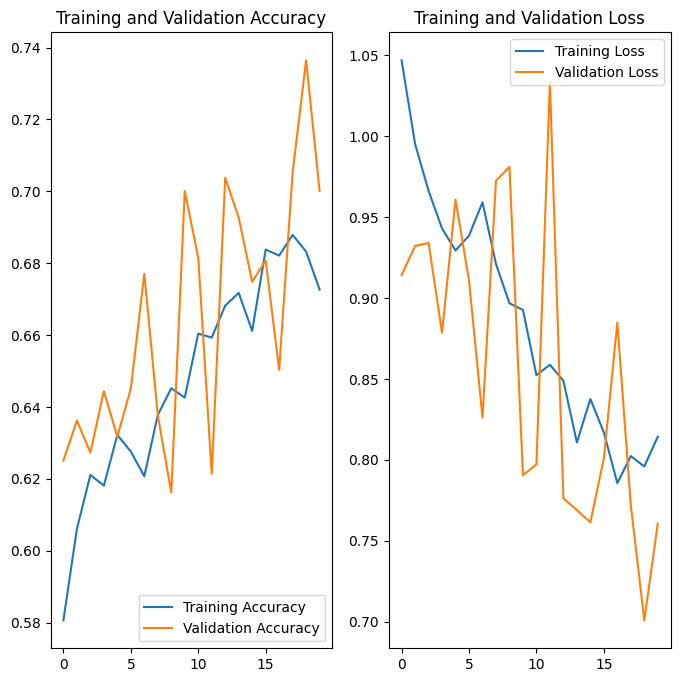

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**The class rebalance has helped in improving the model actually, there's no scenario of Underfitting and Overfitting now, also there's an appropriate accuracy**